[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLO Object Detection on a Custom Dataset

---


## Environment setup

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()  # charge .env dans os.environ
api_key = os.getenv("ROBOFLOW_API_KEY")

### Check GPU availability

In [2]:
!nvidia-smi

/usr/bin/sh: 1: nvidia-smi: not found


In [1]:
import os
HOME = os.getcwd()
print(HOME)

/home/jovyan/notebooks


### Install dependencies

In [2]:
!pip install roboflow supervision opencv-python ultralytics

Defaulting to user installation because normal site-packages is not writeable


### Download example data


In [3]:
!wget https://images.ctfassets.net/ww1ie0z745y7/2kGaAiLQhWyw0XrRmTf0bB/73112c0436b8b25fa03dec90c23e0a2a/Fish-swimming-together.jpg

--2025-06-21 13:42:34--  https://images.ctfassets.net/ww1ie0z745y7/2kGaAiLQhWyw0XrRmTf0bB/73112c0436b8b25fa03dec90c23e0a2a/Fish-swimming-together.jpg
Resolving images.ctfassets.net (images.ctfassets.net)... 18.244.28.44, 18.244.28.26, 18.244.28.109, ...
Connecting to images.ctfassets.net (images.ctfassets.net)|18.244.28.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 376332 (368K) [image/jpeg]
Saving to: ‘Fish-swimming-together.jpg.1’

Fish-swimming-toget 100%[===================>] 367.51K  --.-KB/s    in 0.1s    

2025-06-21 13:42:34 (2.64 MB/s) - ‘Fish-swimming-together.jpg.1’ saved [376332/376332]



## Run inference


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/home/jovyan/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


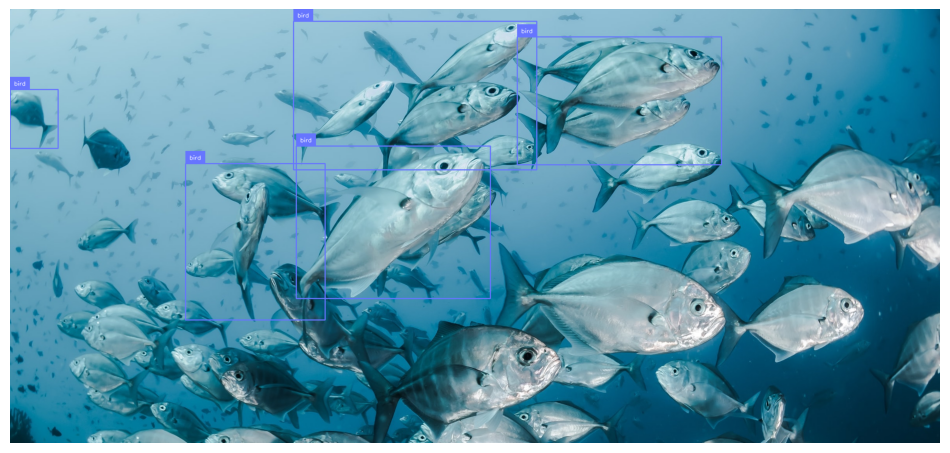

In [4]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/Fish-swimming-together.jpg"
image = cv2.imread(image_path)

model = YOLO('yolov8m.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [5]:
!pip install roboflow

import getpass
from roboflow import Roboflow

api_key = getpass.getpass("Entre ta clé API Roboflow (masquée) : ")

rf = Roboflow(api_key=api_key)
project = rf.workspace("detection-b2dbd").project("combined-fish-id")
version = project.version(4)
dataset = version.download("yolov8")

Defaulting to user installation because normal site-packages is not writeable


Entre ta clé API Roboflow (masquée) :  ········


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Combined-Fish-ID-4 in yolov8:: 100% 2690/2690 [00:08<00:00, 307.29it/s]


In [6]:
!ls {dataset.location}

README.dataset.txt  README.roboflow.txt  data.yaml  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [7]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [8]:
!cat {dataset.location}/data.yaml

names:
- fish
nc: 1
roboflow:
  license: CC BY 4.0
  project: combined-fish-id
  url: https://universe.roboflow.com/detection-b2dbd/combined-fish-id/dataset/4
  version: 4
-e test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLO model


In [9]:
from ultralytics import YOLO

model = YOLO('yolov8m')

results = model.train(data=f'{dataset.location}/data.yaml',  project='/home/jovyan/yolo-training', epochs=20, batch=1, patience=0, save_period=5, save=True, workers=2)

Ultralytics 8.3.157 🚀 Python-3.10.18 torch-2.7.1+cpu CPU (-)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/jovyan/notebooks/Combined-Fish-ID-4/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=0, perspective=0.0, plots=True, pose=12.0, pretrained=Tr

100% 755k/755k [00:00<00:00, 8.58MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           


  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics.nn.modules.conv.Conv             [384, 576, 3, 2]              
  8                  -1  2   3985920  ultralytics.nn.modules.block.C2f             [576, 576, 2, True]           
  9                  -1  1    831168  ultralytics.nn.modules.block.SPPF            [576, 576, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  2   1993728  ultralytics.nn.modules.block.C2f             [960, 384, 2]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None

train: Scanning /home/jovyan/notebooks/Combined-Fish-ID-4/train/labels... 1148 images, 48 backgrounds, 0 corrupt: 100% 1148/1148 [00:03<00:00, 322.63it/s]


train: New cache created: /home/jovyan/notebooks/Combined-Fish-ID-4/train/labels.cache
val: Fast image access ✅ (ping: 0.5±0.1 ms, read: 20.9±8.5 MB/s, size: 35.2 KB)


'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
val: Scanning /home/jovyan/notebooks/Combined-Fish-ID-4/valid/labels... 77 images, 4 backgrounds, 0 corrupt: 100% 77/77 [00:00<00:00, 413.74it/s]


val: New cache created: /home/jovyan/notebooks/Combined-Fish-ID-4/valid/labels.cache


'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.


Plotting labels to /home/jovyan/yolo-training/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /home/jovyan/yolo-training/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G      2.118      2.943      2.132         23        640:   5% 57/1148 [06:48<2:10:19,  7.17s/it]


KeyboardInterrupt: 

## Evaluate fine-tuned YOLOv12 model

In [31]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls /home/jovyan/yolo-training/train5

F1_curve.png			 labels_correlogram.jpg  train_batch2.jpg
PR_curve.png			 results.csv		 val_batch0_labels.jpg
P_curve.png			 results.png		 val_batch0_pred.jpg
R_curve.png			 train_batch0.jpg	 val_batch1_labels.jpg
args.yaml			 train_batch1.jpg	 val_batch1_pred.jpg
confusion_matrix.png		 train_batch1980.jpg	 val_batch2_labels.jpg
confusion_matrix_normalized.png  train_batch1981.jpg	 val_batch2_pred.jpg
labels.jpg			 train_batch1982.jpg	 weights


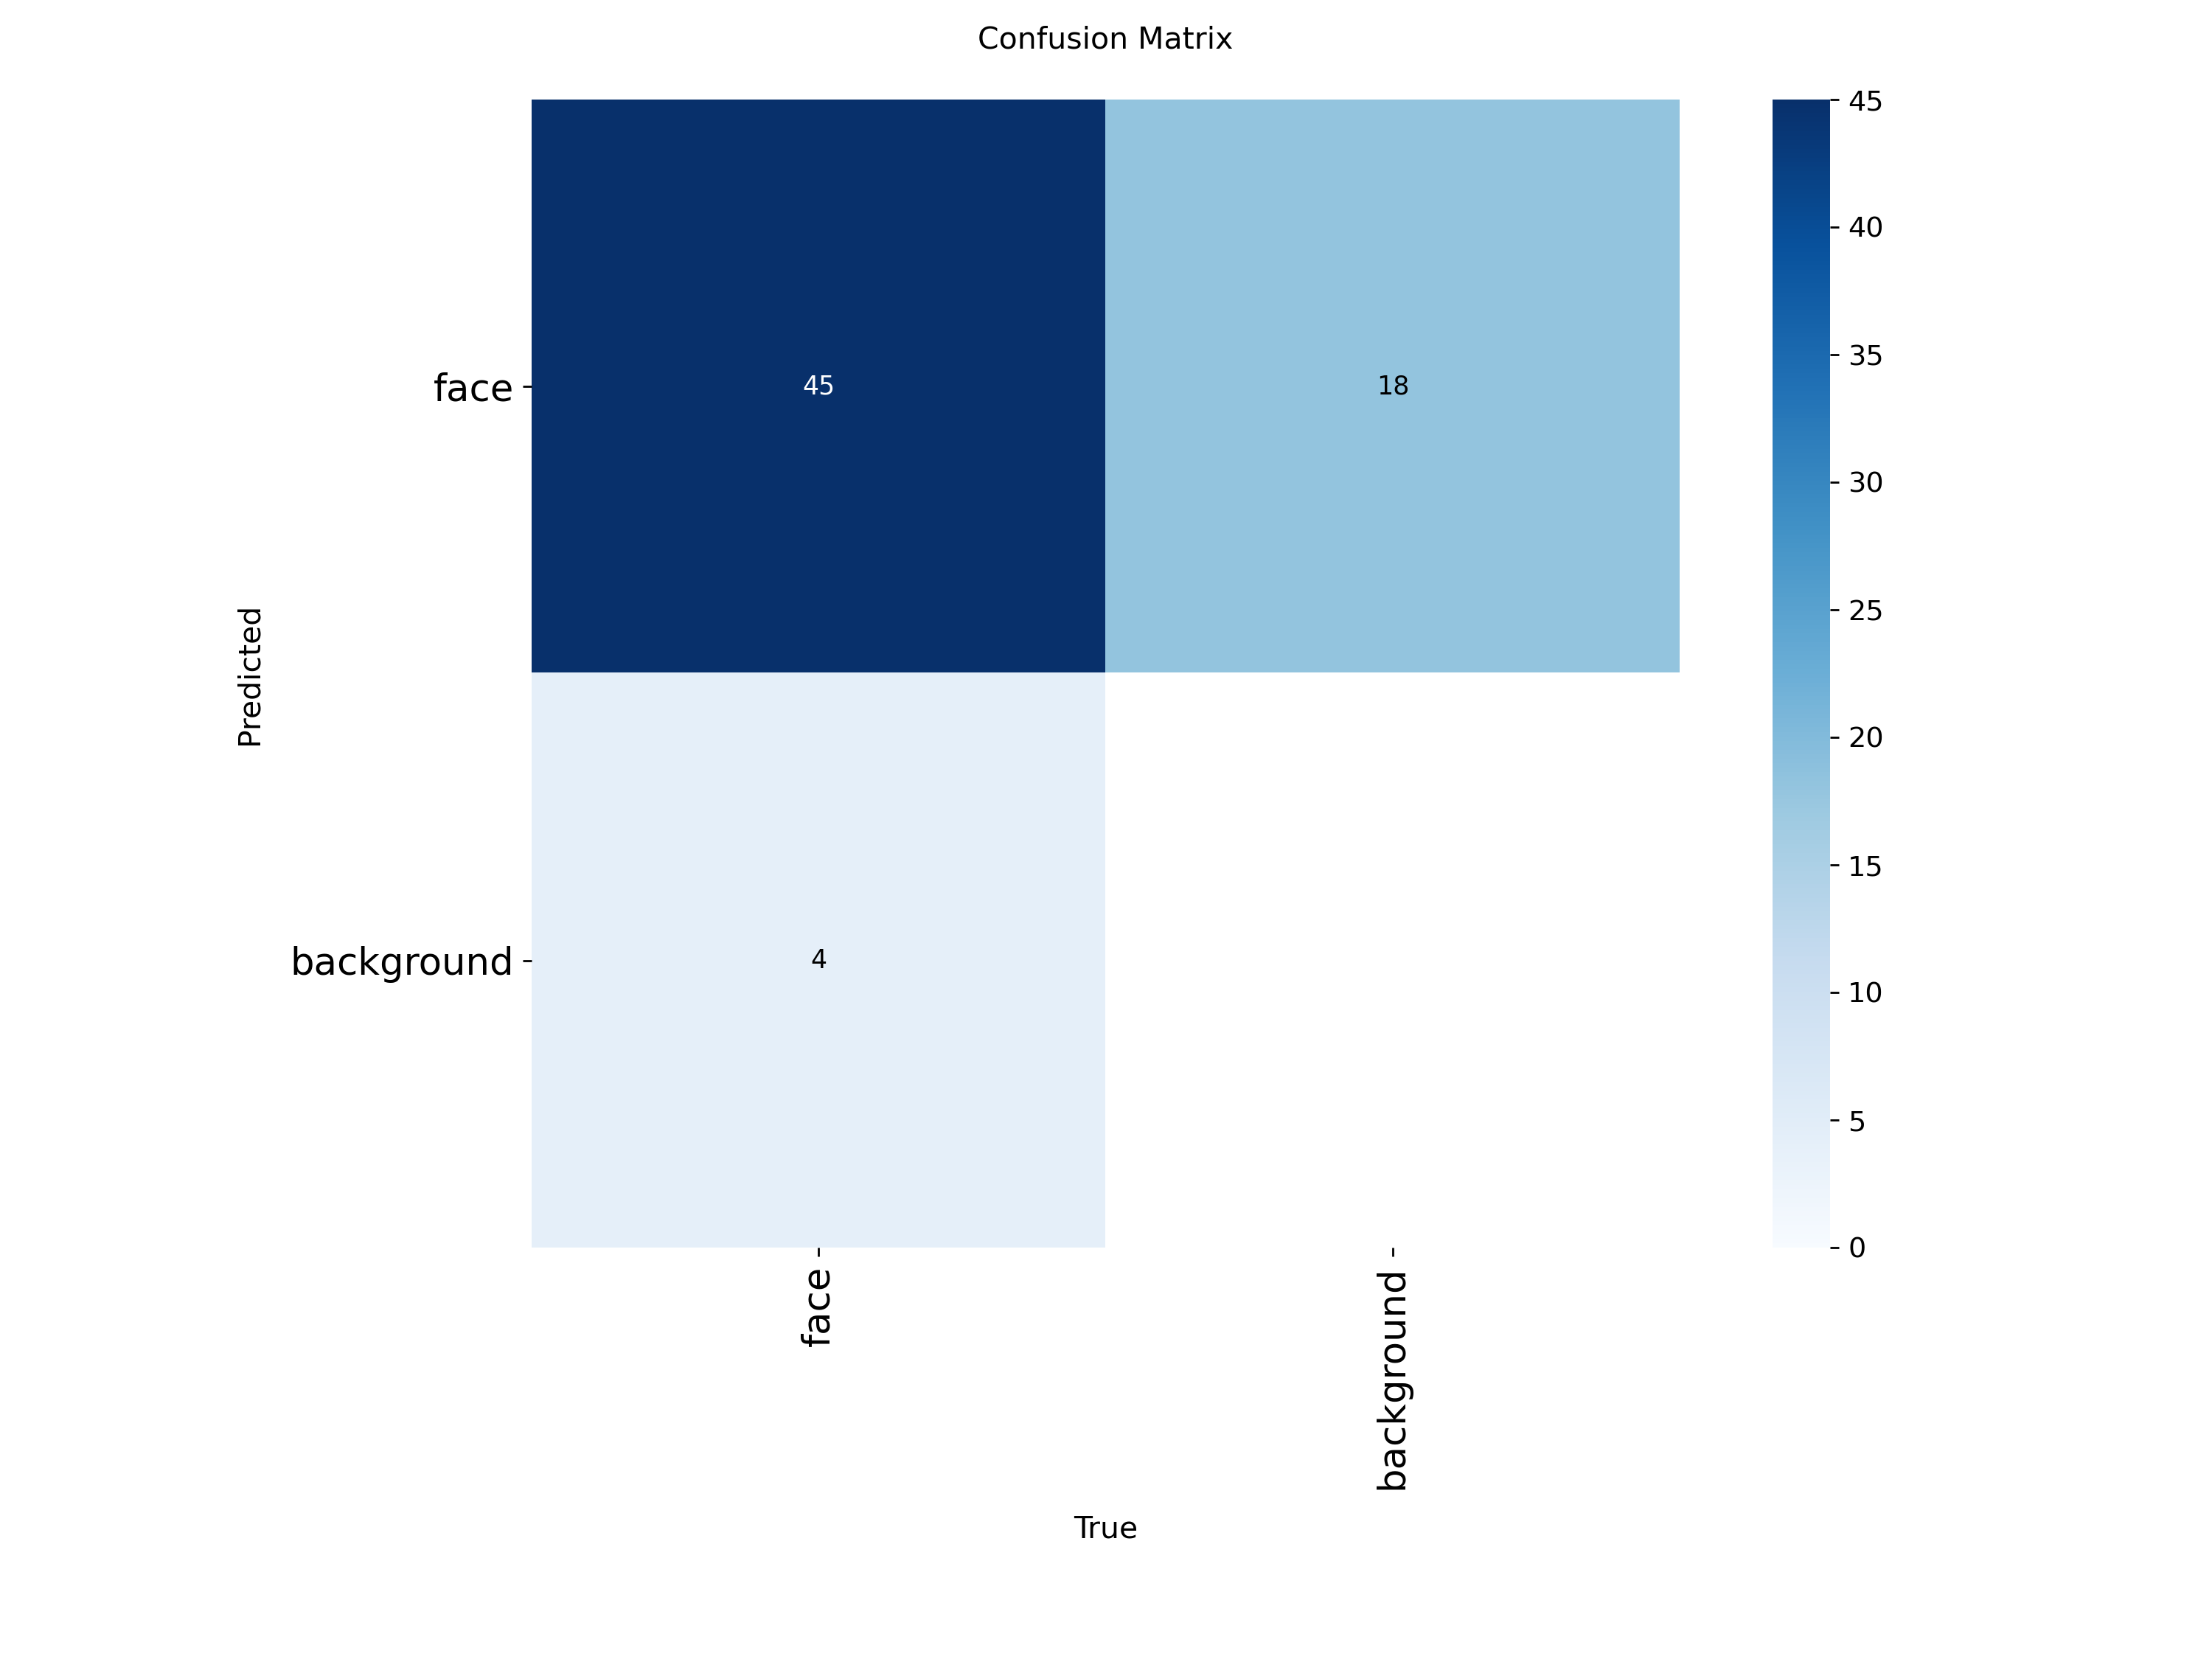

In [32]:
from IPython.display import Image

Image(filename=f'/home/jovyan/yolo-training/train5/confusion_matrix.png', width=1000)

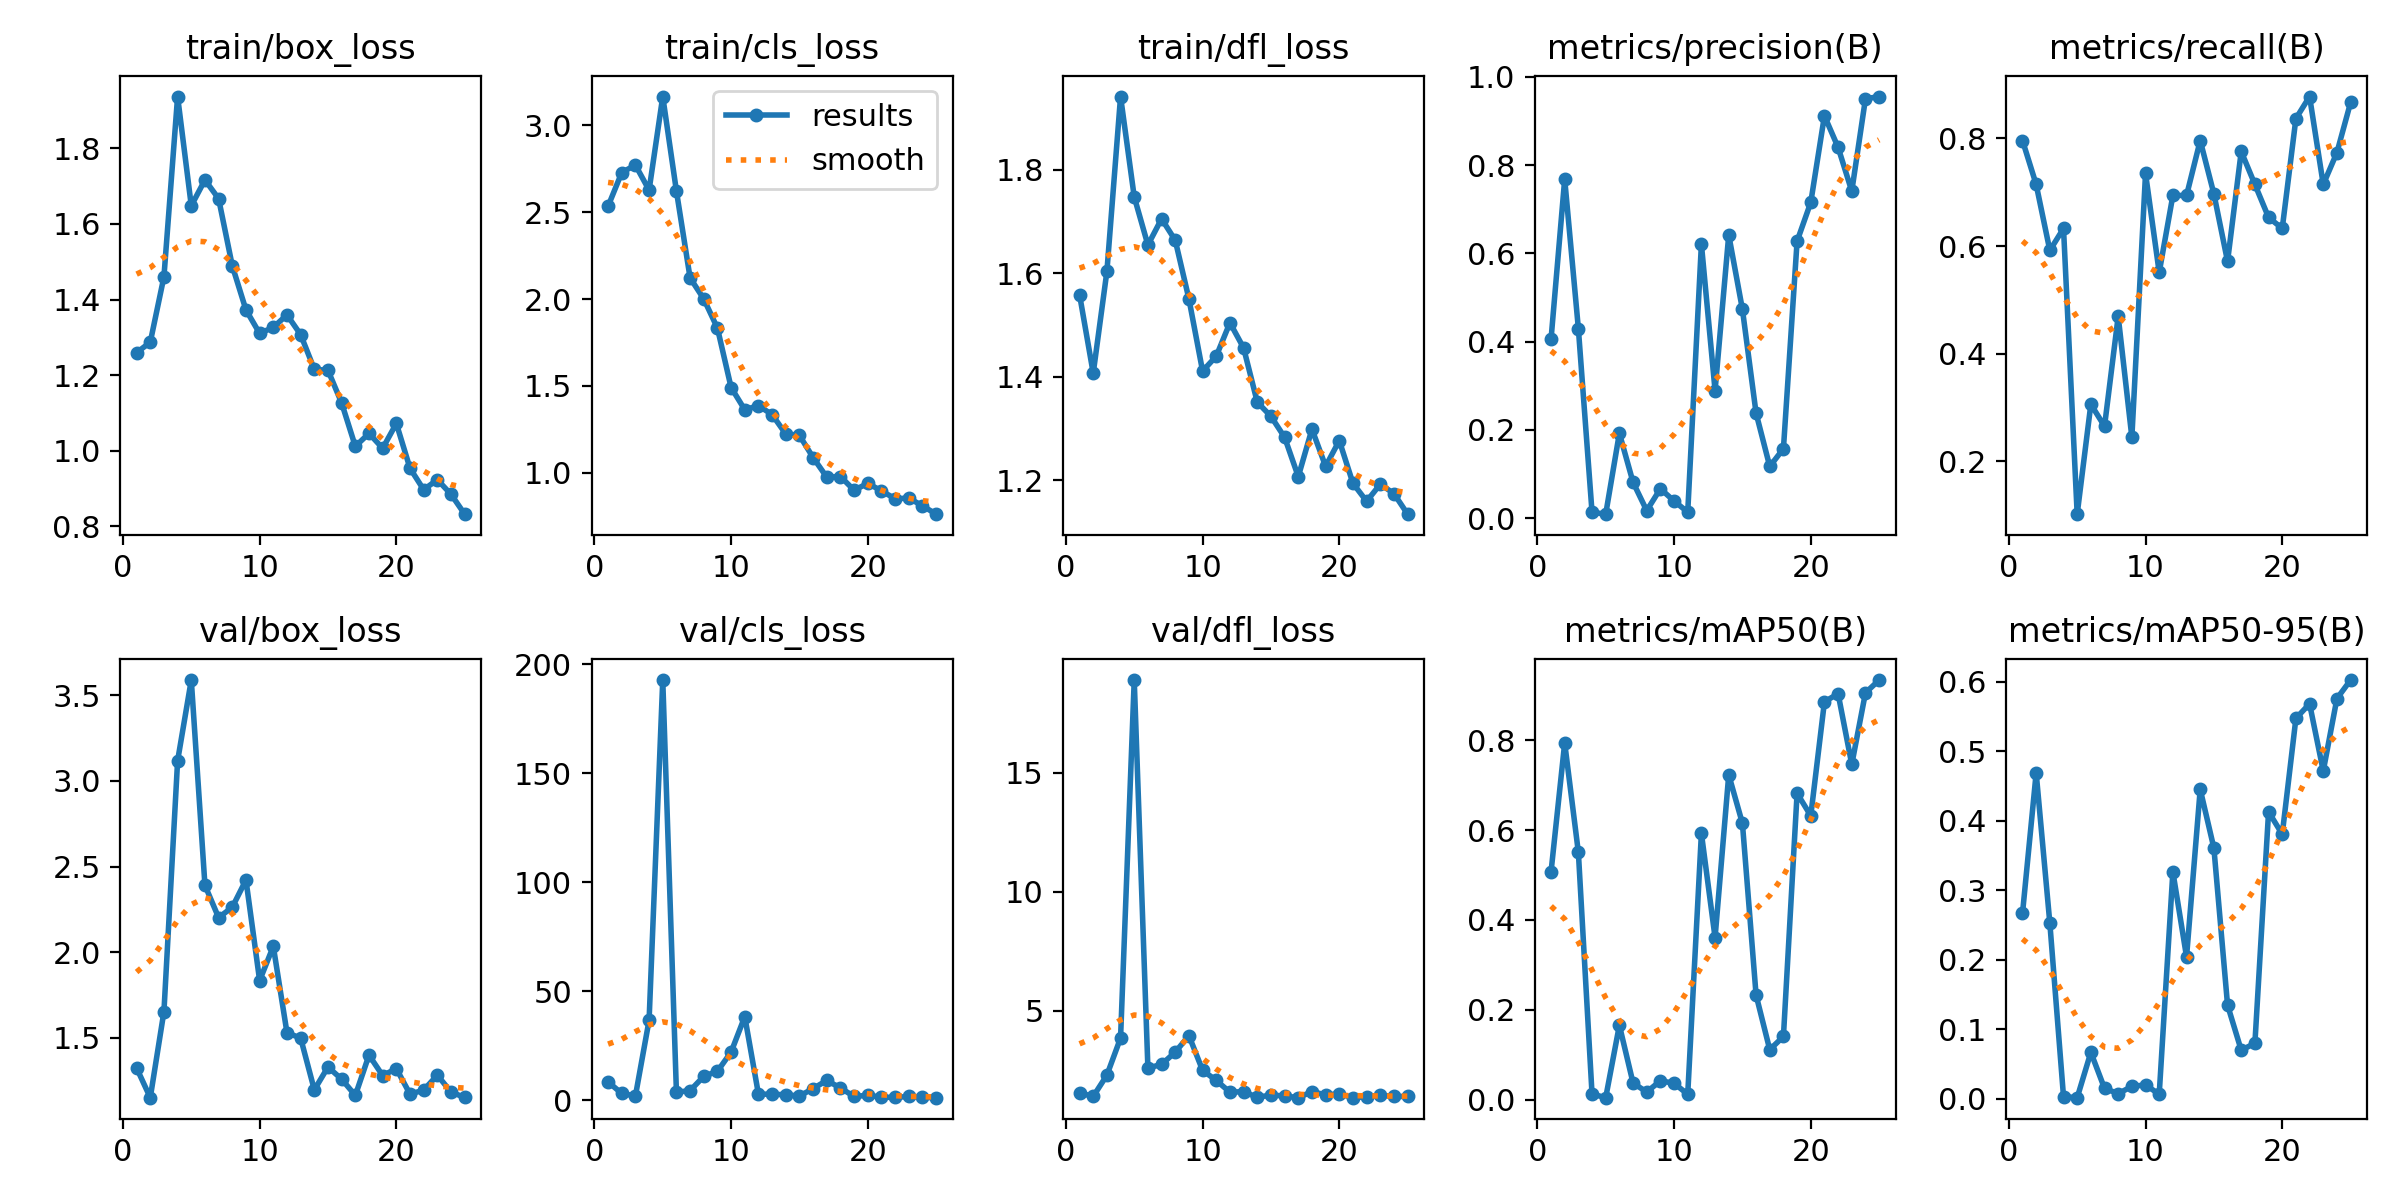

In [33]:
from IPython.display import Image

Image(filename=f'/home/jovyan/yolo-training/train5/results.png', width=1000)

In [34]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['face']

In [35]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/home/jovyan/yolo-training/train5/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [36]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.5724254682644205
mAP 50 0.9060455011018342
mAP 75 0.641629161436786


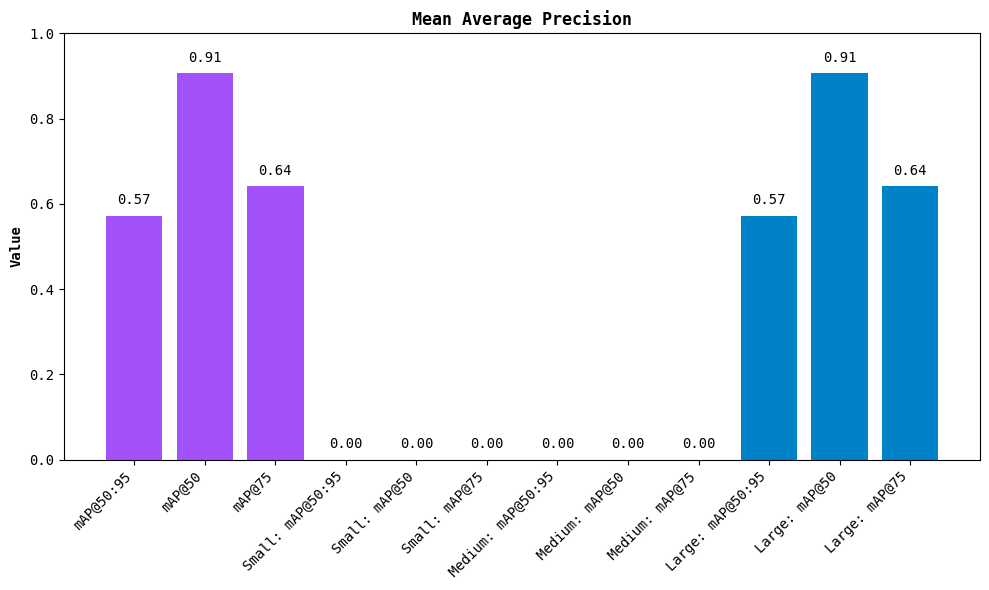

In [37]:
map.plot()

📈 Tes métriques actuelles
Metric	Score	Analyse rapide
mAP@50	0.906 ✅	Excellent → ton modèle détecte bien les objets cibles avec une bonne couverture générale.
mAP@75	0.642 ✅	Bon → ton modèle génère des boîtes bien ajustées dans une majorité de cas.
mAP@50:95	0.572 ✅	Correct à bon → ton modèle reste précis sur plusieurs seuils IoU, ce qui indique une généralisation correcte mais encore améliorable.

🧠 Ce que ça signifie concrètement
📦 Ton modèle repère efficacement les objets, même s’il reste quelques erreurs sur les contours ou dans des cas difficiles.

🧠 Il généralise bien, donc il est probablement apte à détecter des objets sur des images encore jamais vues (même domaine).

🔍 L’amélioration par rapport à avant (0.40 → 0.57 en mAP50:95) montre que tes récents changements sont efficaces.





## Run inference with fine-tuned YOLO model

In [38]:
import supervision as sv

model = YOLO(f'/home/jovyan/yolo-training/train5/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

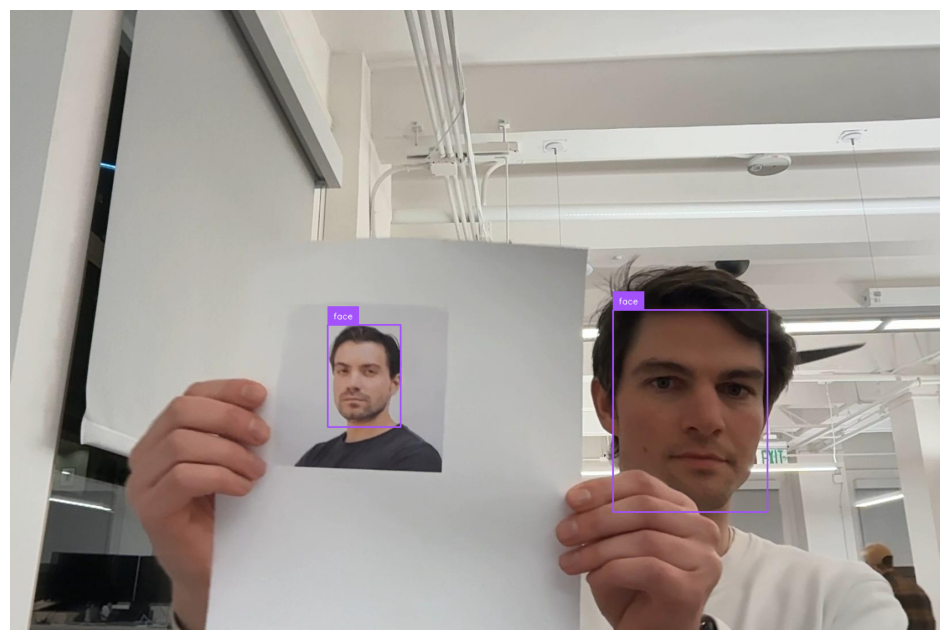

In [42]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

--2025-06-21 11:58:23--  https://github.com/laurent-pereira/ia-face-detector/blob/master/example.jpg?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/laurent-pereira/ia-face-detector/raw/refs/heads/master/example.jpg [following]
--2025-06-21 11:58:23--  https://github.com/laurent-pereira/ia-face-detector/raw/refs/heads/master/example.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/laurent-pereira/ia-face-detector/refs/heads/master/example.jpg [following]
--2025-06-21 11:58:23--  https://raw.githubusercontent.com/laurent-pereira/ia-face-detector/refs/heads/master/example.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (

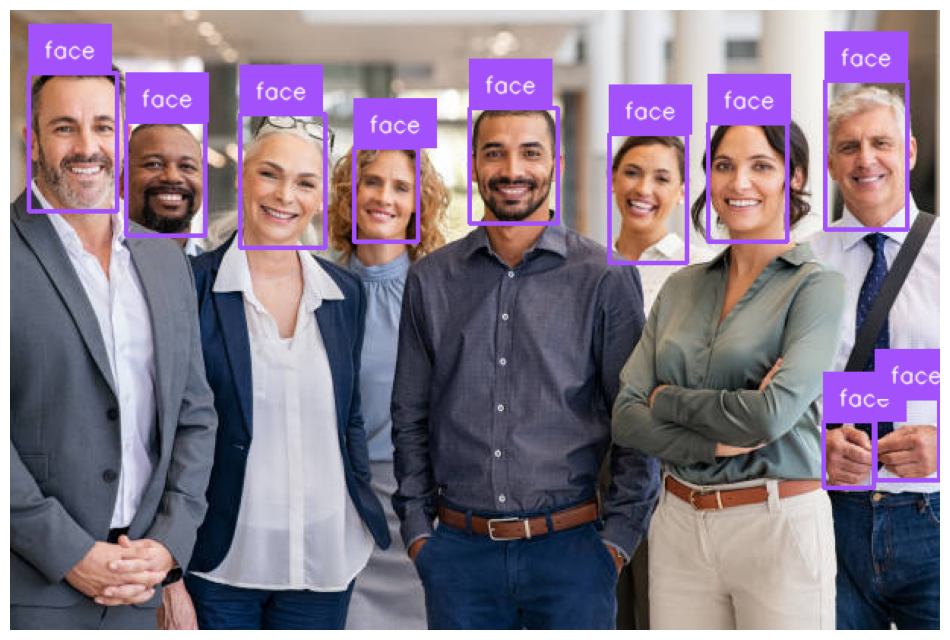

In [44]:
model = YOLO(f'/home/jovyan/yolo-training/train5/weights/best.pt')

!wget https://github.com/laurent-pereira/ia-face-detector/blob/master/example.jpg?raw=true

image_path = f"{HOME}/example.jpg?raw=true"
image = cv2.imread(image_path)

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)